# Tennis Self-paly with SAC (Continuous)

---

This notebook describes the implementation details of the Self-Play SAC agent to solve the Tennis task. All the modules for solving this task is inside the `agent.py` and `utils.py` files and consist of four main components (classes):

- **ReplayBuffer** (`utils.py`)
- **SACAgent** (`agent.py`)
- **GaussianPolicyNet** (`utils.py`)
- **QNet** (`utils.py`)

### Replaybuffer
This module serves as a limited memory to store (using `store()` method) the latest experiences tuple of
`(state, action, reward, next_state, done)` that agent can randomly sample a batch of it for training (using the `sample()` method).

Since each agent receives its own local observation, it is suitable for self-paly and therefore the experience of agents can be store together in a shared replay buffer. 

In [ ]:
class ReplayBuffer:
    def __init__(self,
                 buffer_size=10000,
                 batch_size=64):
        self.state_mem = np.empty(shape=(buffer_size), dtype=np.ndarray)
        self.action_mem = np.empty(shape=(buffer_size), dtype=np.ndarray)
        self.reward_mem = np.empty(shape=(buffer_size), dtype=np.ndarray)
        self.next_state_mem = np.empty(shape=(buffer_size), dtype=np.ndarray)
        self.is_done_mem = np.empty(shape=(buffer_size), dtype=np.ndarray)

        self.max_size = buffer_size
        self.batch_size = batch_size
        self._idx = 0
        self.size = 0

    def store(self, sample):
        state, action, reward, next_state, is_done = sample
        self.state_mem[self._idx] = state
        self.action_mem[self._idx] = action
        self.reward_mem[self._idx] = reward
        self.next_state_mem[self._idx] = next_state
        self.is_done_mem[self._idx] = is_done

        self._idx += 1
        self._idx = self._idx % self.max_size

        self.size += 1
        self.size = min(self.size, self.max_size)

    def sample(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size

        idxs = np.random.choice(
            self.size, batch_size, replace=False)
        experiences = np.vstack(self.state_mem[idxs]), \
                      np.vstack(self.action_mem[idxs]), \
                      np.vstack(self.reward_mem[idxs]), \
                      np.vstack(self.next_state_mem[idxs]), \
                      np.vstack(self.is_done_mem[idxs])
        return experiences

    def __len__(self):
        return self.size

`max_size` and `batch_size` are the hyperparameters alongside the others and all are stored in config dictionary inside `main.py` script:

In [1]:
config = {
    "ROOT_DIR": "results",                  # directory to save the results
    "BUFFER_SIZE": int(1e6),                # replay buffer size
    "BATCH_SIZE": 256,                      # mini-batch size
    "WARMUP_BATCHES": 10,                   # number of initial batches to fill the buffer with
    "TAU": 5e-3,                            # for soft update of target parameters
    "UPDATE_EVERY": 1,                      # how often to update the network
    "SEED": [1],                            # list of the seed to do randomize each training
    "Q_NET_Hidden_Dims": (128, 128),        # Size of the hidden layer in Q-Net
    "Q_LR": 7e-4,                           # Q-Net learning rate
    "Q_MAX_GRAD_NORM": float('inf'),        # to clip gradients of Q-Net
    "POLICY_NET_Hidden_Dims": (64, 64),     # Size of the hidden layer in Policy-Net
    "POLICY_LR": 5e-4,                      # Policy-Net learning rate
    "POLICY_MAX_GRAD_NORM": float('inf'),   # to clip gradients of the Policy-Net

    "ENV_SETTINGS": {
            'ENV_NAME': '../data/Tennis_Linux/Tennis.x86_64',
            'GAMMA': 0.99,
            'MAX_MINUTES': 60,
            'MAX_EPISODES': 2000,
            'GOAL_MEAN_100_REWARD': 0.5
        }
}

### SACAgent: [Maximizing the expected return and entropy](https://spinningup.openai.com/en/latest/algorithms/sac.html)
It's an off-policy algorithm similar to DDPG but with stochastic policy (similar to TD3) instead of a deterministic one (it consists of two modules; Policy Network and Value Network).

The main characteristic is that the entropy of the stochastic policy becomes the part of the value function that agent attempts to maximize;
as in *Entropy-Regularized Reinforcement Learning* (agent gets a bonus reward at each time step proportional to the entropy of the policy at that timestep).

Thus, the one iteration of the training looks like this:

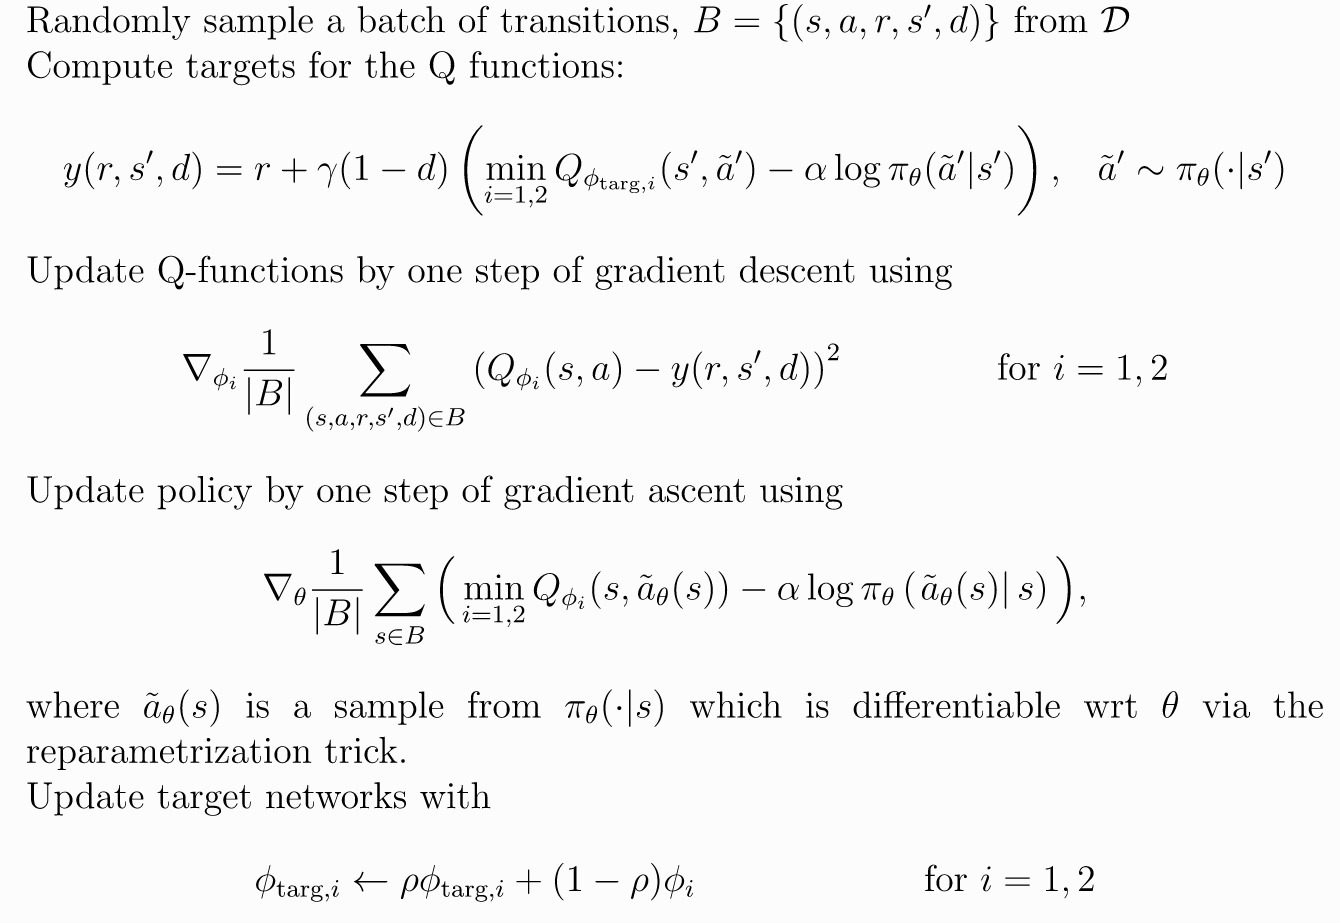

In [3]:
from IPython.display import Image
Image('SAC_Training.png')

Notic that:

- *d* indicates whether $s'$ is terminal or not.
- $\alpha$ tunes the importance we give to the entropy (which in our case is learned as well).
- To avoid the problem of over-estimating the Q-values; two Q-networks are trained and the min. is used for value-targets and policy-objective.

Finally here is the code for the SAC agent and the main methods are:
- `train(...)`: main method that is called from the main code (i.e.: `trainer.py`).
    - `interaction_step(state, env)`: used to collect experiences from the environment by taking the action calculated by policy from the given state.
       It is then added to the replaybuffer.
    - `optimize_model(experiences)`: next, the experiences are used to calculate the value-targets and policy objective to optimize them using gradient descent.

In [4]:
class SACAgent:
    def __init__(self,
                 replay_buffer_fn,
                 policy_model_fn,
                 policy_optimizer_fn,
                 value_model_fn,
                 value_optimizer_fn,
                 config):

        self.replay_buffer_fn = replay_buffer_fn

        self.policy_model_fn = policy_model_fn
        self.policy_optimizer_fn = policy_optimizer_fn
        self.policy_max_grad_norm = config["POLICY_MAX_GRAD_NORM"]
        self.policy_optimizer_lr = config["POLICY_LR"]

        self.value_model_fn = value_model_fn
        self.value_optimizer_fn = value_optimizer_fn
        self.value_max_grad_norm = config["Q_MAX_GRAD_NORM"]
        self.value_optimizer_lr = config["Q_LR"]

        self.n_warmup_batches = config["WARMUP_BATCHES"]
        self.update_target_every_steps = config["UPDATE_EVERY"]

        self.tau = config["TAU"]
        self.root_dir = config["ROOT_DIR"]

    def setup(self, nS, nA, acts_bounds):

        self.target_value_model_a = self.value_model_fn(nS, nA)
        self.online_value_model_a = self.value_model_fn(nS, nA)

        self.target_value_model_b = self.value_model_fn(nS, nA)
        self.online_value_model_b = self.value_model_fn(nS, nA)

        self.update_value_networks()

        self.policy_model = self.policy_model_fn(nS, acts_bounds)

        self.value_optimizer_a = self.value_optimizer_fn(self.online_value_model_a,
                                                         self.value_optimizer_lr)
        self.value_optimizer_b = self.value_optimizer_fn(self.online_value_model_b,
                                                         self.value_optimizer_lr)
        self.policy_optimizer = self.policy_optimizer_fn(self.policy_model,
                                                         self.policy_optimizer_lr)

        self.replay_buffer = self.replay_buffer_fn()

    def optimize_model(self, experiences):
        states, actions, rewards, next_states, is_terminals = experiences
        batch_size = is_terminals.shape[0]

        # policy loss
        current_actions, logpi_s, _ = self.policy_model.full_pass(states)

        target_alpha = (logpi_s + self.policy_model.target_entropy).detach()
        alpha_loss = -(self.policy_model.logalpha * target_alpha).mean()

        self.policy_model.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.policy_model.alpha_optimizer.step()
        alpha = self.policy_model.logalpha.exp()

        # Q loss
        ap, logpi_sp, _ = self.policy_model.full_pass(next_states)
        q_spap_a = self.target_value_model_a(next_states, ap)
        q_spap_b = self.target_value_model_b(next_states, ap)
        q_spap = torch.min(q_spap_a, q_spap_b) - alpha * logpi_sp
        target_q_sa = (rewards + self.gamma * q_spap * (1 - is_terminals)).detach()

        q_sa_a = self.online_value_model_a(states, actions)
        q_sa_b = self.online_value_model_b(states, actions)
        qa_loss = (q_sa_a - target_q_sa).pow(2).mul(0.5).mean()
        qb_loss = (q_sa_b - target_q_sa).pow(2).mul(0.5).mean()

        self.value_optimizer_a.zero_grad()
        qa_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_value_model_a.parameters(),
                                       self.value_max_grad_norm)
        self.value_optimizer_a.step()

        self.value_optimizer_b.zero_grad()
        qb_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_value_model_b.parameters(),
                                       self.value_max_grad_norm)
        self.value_optimizer_b.step()

        current_q_sa_a = self.online_value_model_a(states, current_actions)
        current_q_sa_b = self.online_value_model_b(states, current_actions)
        current_q_sa = torch.min(current_q_sa_a, current_q_sa_b)
        policy_loss = (alpha * logpi_s - current_q_sa).mean()

        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_model.parameters(),
                                       self.policy_max_grad_norm)
        self.policy_optimizer.step()

        log_dict = {"critic_a_loss": qa_loss.item(), "critic_b_loss": qb_loss.item(),
                    "logpi_s": logpi_s, "logpi_sp": logpi_sp,
                    "policy_loss": policy_loss.item(), "alpha_loss": alpha_loss.item(), "alpha": alpha}
        for k in log_dict.keys():
            if type(log_dict[k]) == float:
                mlflow.log_metric(k, log_dict[k], self.episode)

    def interaction_step(self, states, env):
        min_samples = self.replay_buffer.batch_size * self.n_warmup_batches

        if len(self.replay_buffer) < min_samples:
            actions = np.array([self.policy_model.select_random_action() for _ in range(self.num_agents)])
        else:
            actions = np.array([self.policy_model.select_action(states[i]) for i in range(self.num_agents)])

        env_info = env.step(actions)[self.brain_name]
        new_states, rewards, is_terminal = env_info.vector_observations, np.array(env_info.rewards), np.array(env_info.local_done, dtype=np.float32)

        [self.replay_buffer.store((states[i], actions[i], rewards[i], new_states[i], is_terminal[i])) for i in range(self.num_agents)]

        self.episode_reward[-1] += rewards
        self.episode_timestep[-1] += 1
        return new_states, is_terminal

    def update_value_networks(self, tau=None):
        tau = self.tau if tau is None else tau

        for target, online in zip(self.target_value_model_a.parameters(),
                                  self.online_value_model_a.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

        for target, online in zip(self.target_value_model_b.parameters(),
                                  self.online_value_model_b.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

    def train(self, env, seed, gamma,
              max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')

        self.checkpoint_dir = tempfile.mkdtemp()
        self.seed = seed
        self.gamma = gamma

        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        random.seed(self.seed)

        self.brain_name = env.brain_names[0]  # get the default brain
        self.brain = env.brains[self.brain_name]
        env_info = env.reset(train_mode=True)[self.brain_name]
        self.num_agents = len(env_info.agents)

        nS, nA = self.brain.vector_observation_space_size*self.brain.num_stacked_vector_observations, self.brain.vector_action_space_size
        action_bounds = [-1 for _ in range(nA)], [1 for _ in range(nA)]
        self.setup(nS, nA, action_bounds)

        self.episode_timestep = []
        self.episode_seconds = []
        self.episode_reward = np.zeros((1, self.num_agents))
        self.evaluation_scores = []

        result = np.empty((max_episodes, 6))
        result[:] = np.nan
        training_time = 0
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            self.episode = episode

            env_info = env.reset(train_mode=True)[self.brain_name]
            state, is_terminal, rewards = env_info.vector_observations, np.array(env_info.local_done, dtype=np.float32), np.array(env_info.rewards)

            if episode != 0: self.episode_reward = np.concatenate([self.episode_reward, np.zeros((1, self.num_agents))], axis=0)
            self.episode_timestep.append(0.0)

            for _ in count():
                state, is_terminal = self.interaction_step(state, env)

                min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
                if len(self.replay_buffer) > min_samples:
                    experiences = self.replay_buffer.sample()
                    experiences = self.online_value_model_a.load(experiences)
                    self.optimize_model(experiences)

                if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
                    self.update_value_networks()

                if np.any(is_terminal):
                    gc.collect()
                    break

            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score, _ = self.evaluate(self.policy_model, env)
            self.save_checkpoint(episode - 1, self.policy_model)

            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)

            mean_10_reward = np.mean(np.max(self.episode_reward[-10:, :], axis=-1))
            std_10_reward = np.std(np.max(self.episode_reward[-10:, :], axis=-1))
            mean_100_reward = np.mean(np.max(self.episode_reward[-100:, :], axis=-1))
            std_100_reward = np.std(np.max(self.episode_reward[-100:, :], axis=-1))
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:, :])
            std_100_eval_score = np.std(self.evaluation_scores[-100:, :])

            log_dict = {"mean_10_reward": mean_10_reward,
                        "std_10_reward": std_10_reward,
                        "mean_100_reward": mean_100_reward,
                        "std_100_reward": std_100_reward,
                        "mean_100_eval_score": mean_100_eval_score,
                        "std_100_eval_score": std_100_eval_score}
            mlflow.log_metrics(log_dict, episode)

            wallclock_elapsed = time.time() - training_start
            result[episode - 1] = total_step, np.max(self.episode_reward[episode - 1]), mean_100_reward, \
                                  mean_100_eval_score, training_time, wallclock_elapsed

            reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
            reached_max_minutes = wallclock_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_reward >= goal_mean_100_reward
            training_is_over = reached_max_minutes or \
                               reached_max_episodes or \
                               reached_goal_mean_reward
            elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start))
            debug_message = f'elapsed {elapsed_str}, episode {episode - 1}, steps {total_step}, '
            debug_message += f'ave_r 10 {mean_10_reward}\u00B1{std_10_reward}, '
            debug_message += f'ave_r 100 {mean_100_reward}\u00B1{std_100_reward}, '
            debug_message += f'ave_eval 100 {mean_100_eval_score}\u00B1{std_100_eval_score}'

            print(debug_message, end='\r', flush=True)
            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message, flush=True)
                last_debug_time = time.time()
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward of +0.5 over last 100 episodes \u2713')
                break

        final_eval_score, score_std = self.evaluate(self.policy_model, env, n_episodes=100)
        wallclock_time = time.time() - training_start
        print('Training complete.')
        print(f'Final evaluation score {final_eval_score}\u00B1{score_std} in {training_time}s training time,'
              f' {wallclock_time}s wall-clock time.\n')

        self.save_checkpoint('final', self.policy_model)
        return result, final_eval_score, training_time, wallclock_time

    def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
        rs = np.zeros((1, self.num_agents))
        for i in range(n_episodes):
            env_info = eval_env.reset(train_mode=True)[self.brain_name]
            s, d = env_info.vector_observations, np.array(env_info.local_done, dtype=np.float32)
            if i != 0: rs = np.concatenate([rs, np.zeros((1, self.num_agents))], axis=0)
            for _ in count():
                a = np.array([eval_policy_model.select_greedy_action(s[i]) for i in range(self.num_agents)])
                env_info = eval_env.step(a)[self.brain_name]
                s, r, d = env_info.vector_observations, np.array(env_info.rewards), np.array(env_info.local_done, dtype=np.float32)
                rs[-1] += r
                if np.any(d): break
        return np.mean(np.max(rs, axis=-1)), np.std(np.max(rs, axis=-1))

    def save_checkpoint(self, episode_idx, model):
        torch.save(model.state_dict(),
                   os.path.join(self.root_dir if episode_idx == 'final' else self.checkpoint_dir,
                                'model_{}.pth'.format(episode_idx)))


### Policy-Network:
It is implemented as a simple dense network with two hidden layers with `ReLU` nonlinearity and a `tanh` output layer
(to bound the actions to [-1, 1]).

Helper functions added to make it easeir to sample different kinds of actions we want from the policy;
 i.e.:
 - random (`select_random_action()`),
 - greedy (`select_greedy_action(state)`)
 - or stochastic (`select_action(state)`).

In [9]:
class GaussianPolicyNet(nn.Module):
    def __init__(self,
                 input_dim,
                 action_bounds,
                 log_std_min=-20,
                 log_std_max=2,
                 hidden_dims=(32, 32),
                 activation_fc=F.relu,
                 entropy_lr=0.001):
        super(GaussianPolicyNet, self).__init__()
        self.activation_fc = activation_fc
        self.env_min, self.env_max = action_bounds

        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

        self.input_layer = nn.Linear(input_dim,
                                     hidden_dims[0])

        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            hidden_layer = nn.Linear(
                hidden_dims[i], hidden_dims[i + 1])
            self.hidden_layers.append(hidden_layer)

        self.output_layer_mean = nn.Linear(hidden_dims[-1], len(self.env_max))
        self.output_layer_log_std = nn.Linear(hidden_dims[-1], len(self.env_max))

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

        self.env_min = torch.tensor(self.env_min,
                                    device=self.device,
                                    dtype=torch.float32)

        self.env_max = torch.tensor(self.env_max,
                                    device=self.device,
                                    dtype=torch.float32)

        self.action_shape = self.env_max.cpu().numpy().shape

        self.nn_min = F.tanh(torch.Tensor([float('-inf')])).to(self.device)
        self.nn_max = F.tanh(torch.Tensor([float('inf')])).to(self.device)
        self.rescale_fn = lambda x: (x - self.nn_min) * (self.env_max - self.env_min) / \
                                    (self.nn_max - self.nn_min) + self.env_min

        self.target_entropy = float(-np.prod(self.env_max.shape))
        self.logalpha = torch.zeros(1, requires_grad=True, device=self.device)
        self.alpha_optimizer = optim.Adam([self.logalpha], lr=entropy_lr)

    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x,
                             device=self.device,
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        return x

    def forward(self, state):
        x = self._format(state)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x_mean = self.output_layer_mean(x)
        x_log_std = self.output_layer_log_std(x)
        x_log_std = torch.clamp(x_log_std,
                                self.log_std_min,
                                self.log_std_max)
        return x_mean, x_log_std

    def full_pass(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)

        pi_s = Normal(mean, log_std.exp())
        pre_tanh_action = pi_s.rsample()
        tanh_action = torch.tanh(pre_tanh_action)
        action = self.rescale_fn(tanh_action)

        log_prob = pi_s.log_prob(pre_tanh_action) - \
                   torch.log((1 - tanh_action.pow(2)).clamp(0, 1) + epsilon)
        log_prob = log_prob.sum(dim=1, keepdim=True)

        return action, log_prob, self.rescale_fn(torch.tanh(mean))

    def select_random_action(self):
        return np.random.uniform(low=self.env_min.cpu().numpy(),
                                 high=self.env_max.cpu().numpy()).reshape(self.action_shape)

    def select_greedy_action(self, state):
        return self.rescale_fn(torch.tanh(self.forward(state)[0])).detach().cpu().numpy().reshape(self.action_shape)

    def select_action(self, state):
        mean, log_std = self.forward(state)
        action = self.rescale_fn(torch.tanh(Normal(mean, log_std.exp()).sample()))
        return action.detach().cpu().numpy().reshape(self.action_shape)

### Q-Network:
It is implemented as a simple dense network with two hidden layers with `ReLU` nonlinearity and a linear output layer.

Two of them is used in SAC agent for more stable training (reducing over-estimation of values by taking the min. of the two).

Here is the architecture:

In [ ]:
class QNet(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim,
                 hidden_dims=(32, 32),
                 activation_fc=F.relu):
        super(QNet, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim + output_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i + 1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], 1)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

    def _format(self, state, action):
        x, u = state, action
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x,
                             device=self.device,
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        if not isinstance(u, torch.Tensor):
            u = torch.tensor(u,
                             device=self.device,
                             dtype=torch.float32)
            u = u.unsqueeze(0)
        return x, u

    def forward(self, state, action) -> torch.Tensor:
        x, u = self._format(state, action)
        x = self.activation_fc(self.input_layer(torch.cat((x, u), dim=1)))
        for i, hidden_layer in enumerate(self.hidden_layers):
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        return x

    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).float().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

### trainer.py

This is the main scripts that used for running the experiments; the agent module together with the environment is used to train the agent (using the train() method) and to keep track of its learning behavior.

In [ ]:
def train(env):

    # Creating the required directories
    current_date = str(date.today()).replace('-', '_')
    current_time = utils.get_date_time_now()
    config["ROOT_DIR"] = os.path.join(config["ROOT_DIR"], current_date, current_time)
    os.makedirs(config["ROOT_DIR"], exist_ok=True)

    exp_results = []
    best_agent, best_eval_score = None, float('-inf')
    for seed in config["SEED"]:

        _, gamma, max_minutes, max_episodes, goal_mean_100_reward = config["ENV_SETTINGS"].values()

        agent = create_agent(config)
        result, final_eval_score, training_time, wallclock_time = agent.train(env,
                                                                              seed,
                                                                              gamma,
                                                                              max_minutes,
                                                                              max_episodes,
                                                                              goal_mean_100_reward)

        exp_results.append(result)
        if final_eval_score > best_eval_score:
            best_eval_score = final_eval_score
            best_agent = agent

    process_results(exp_results, config["ROOT_DIR"])
    return best_agent

### Let's train the agent!
Run **`python trainer.py`** in the terminal:

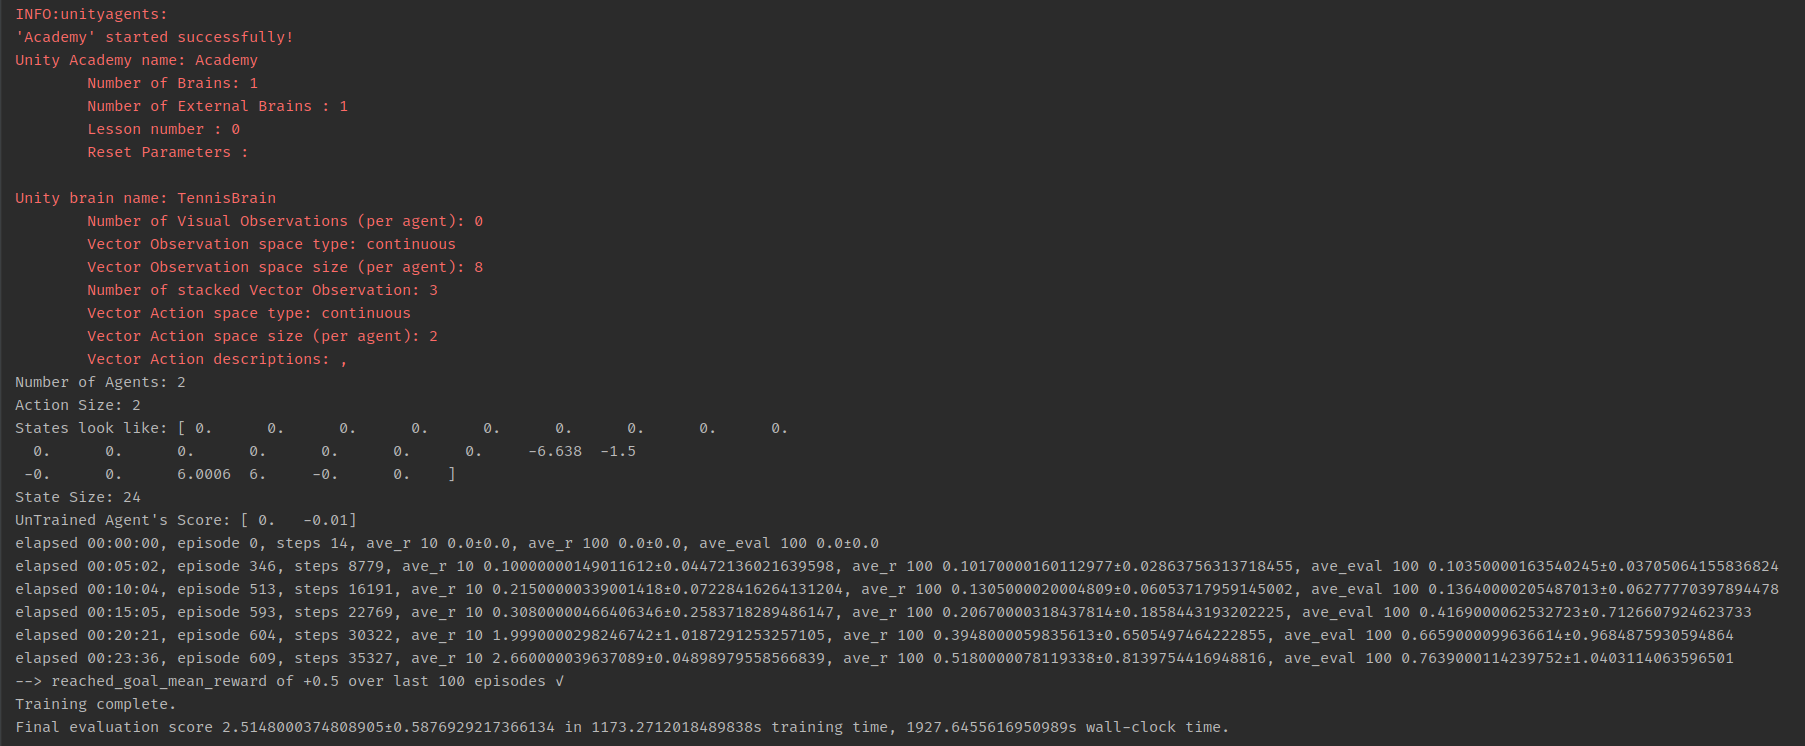

In [3]:
from IPython.display import Image
Image('terminal_outputs.png')

### Let's see the Learning-Curve

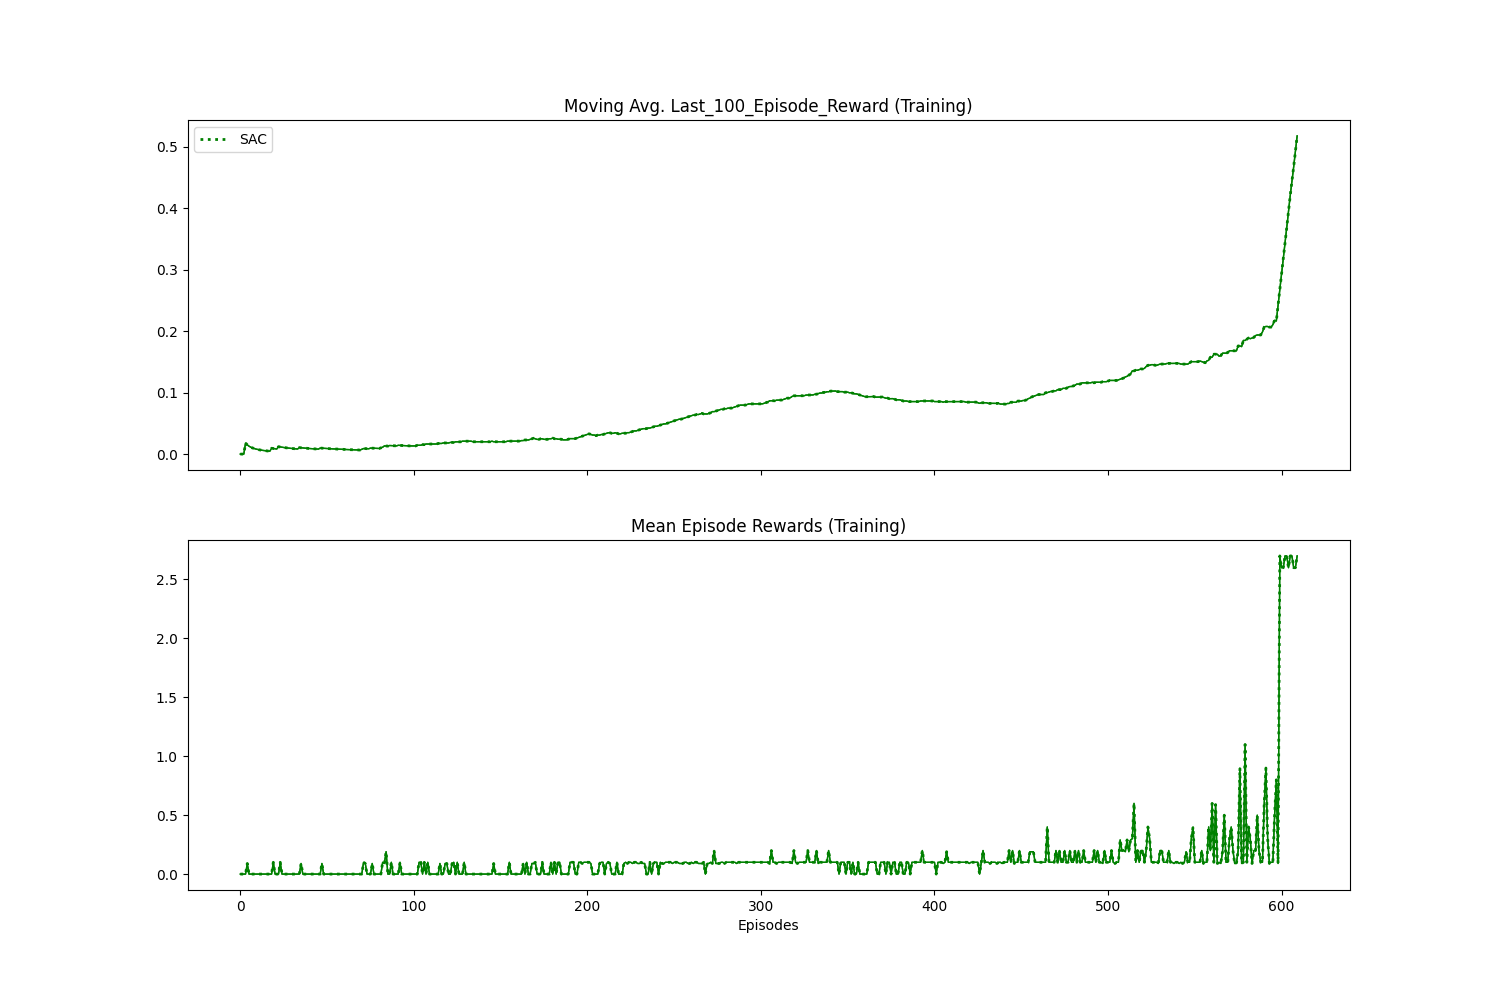

In [2]:
Image('learning_curve.png')


### Ideas for Future Work

There are lots of extension to this agent!

- First would be to try to learn the task from raw pixels using ConvsNet as encoder.
- Second would be to assess the affect of using LayerNorm and Weight_Norm in the architecture of the QNetwork to see if there are any improvements in terms of robustness (when tried on different seeds) and training speed.
- Third would be to extend the method to be more data-efficient like the `Dreamer` algorithm by boosting the training of SAC agent using a learned transition model.
